In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# -------------------------
# 1. Load dataset
# -------------------------
df = pd.read_csv("ObesityDataSet.csv")
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

In [5]:
# Map binary string features to numeric
binary_map = {'yes': 1, 'no': 0}
binary_features = ['FAVC','SMOKE','SCC','family_history_with_overweight']
for col in binary_features:
    df[col] = df[col].map(binary_map)

In [6]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

In [8]:
# -------------------------
# Train/Test split (80/20)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [9]:
# -------------------------
# Define feature types
# -------------------------
# Feature lists
numeric_features = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
categorical_features = ['Gender','CAEC','CALC','MTRANS']


In [10]:
# -------------------------
# 2. Preprocess for Naive Bayes
# -------------------------
# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

# One-hot encode categorical features
X_train_cat = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_test_cat = pd.get_dummies(X_test[categorical_features], drop_first=True)

# Align test set columns with training set
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Binary features
X_train_bin = X_train[binary_features].values
X_test_bin = X_test[binary_features].values

# Combine numeric + categorical + binary
X_train_nb = np.hstack([X_train_num, X_train_cat.values, X_train_bin])
X_test_nb = np.hstack([X_test_num, X_test_cat.values, X_test_bin])

=== Gaussian Naive Bayes Evaluation Metrics ===
Accuracy: 0.4941
AUC Score: 0.8336
Precision: 0.5131
Recall: 0.4941
F1 Score: 0.4435
MCC Score: 0.4333


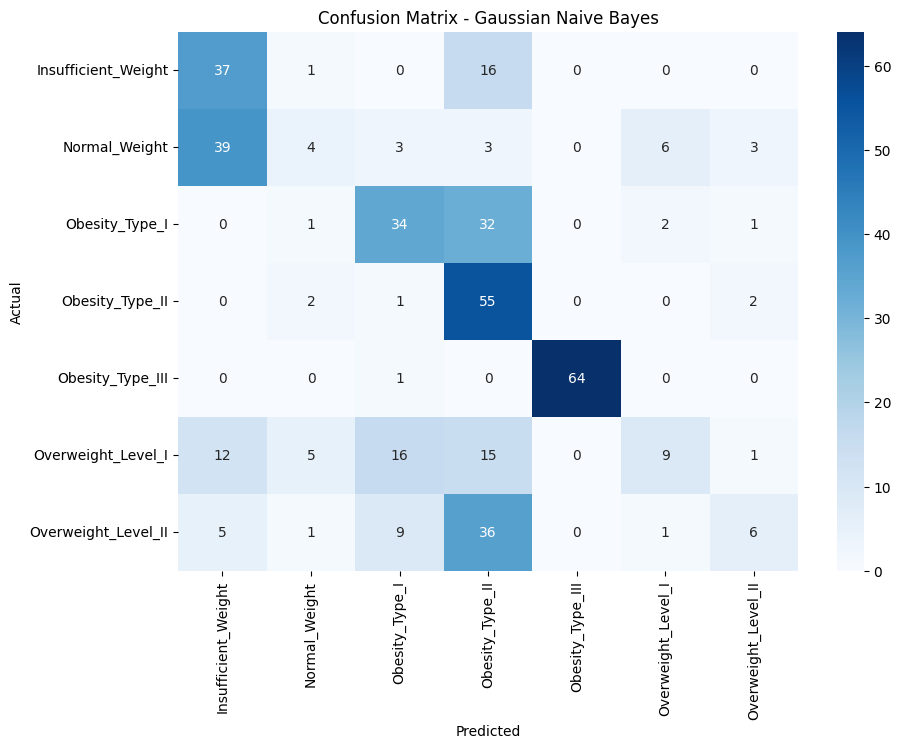

In [11]:
# -------------------------
# Train Gaussian Naive Bayes
# -------------------------
gnb = GaussianNB()
gnb.fit(X_train_nb, y_train)

# -------------------------
# 4. Predict
# -------------------------
y_pred = gnb.predict(X_test_nb)
y_prob = gnb.predict_proba(X_test_nb)

# -------------------------
# 5. Evaluation Metrics
# -------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(pd.get_dummies(y_test), y_prob, multi_class='ovr', average='weighted')

print("=== Gaussian Naive Bayes Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")

# -------------------------
# 6. Confusion Matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

In [12]:
import os
os.makedirs('model', exist_ok=True)

# Save scaler for numeric features
joblib.dump(scaler, 'model/nb_scaler.pkl')

# Save list of categorical columns (needed for alignment in future)
joblib.dump(X_train_cat.columns.tolist(), 'model/nb_cat_columns.pkl')

# Save trained Naive Bayes model
joblib.dump(gnb, 'model/naive_bayes_model.pkl')

print("✅ Naive Bayes model and preprocessing objects saved successfully!")

✅ Naive Bayes model and preprocessing objects saved successfully!
